In [2]:
from datetime import datetime as dt

print('Last accessed on: {}'.format(dt.now()))

Last accessed on: 2016-12-18 20:07:11.730000


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Hot Jupiters

[Hot Jupiters](https://en.wikipedia.org/wiki/Hot_Jupiter) are a rare and peculiar class of exoplanet that have masses comparable to that of Jupiter and short orbital periods of typically four to five days. HJs are typically defined as planets with masses $\gtrsim$0.1 M$_{Jup}$ on orbits with periods $P$ less than about 10 days (e.g., Gaudi et al. 2005; Wright et al. 2012). Warm Jupiters (WJs) are similar, but have orbits with longer periods out to the postulated water ice line ($\sim$1 AU).

About 10% of FGK stars in the solar neighborhood harbor a giant planet at periods between 2 and 2000 days (Cumming et al. 2008; Howard 2013), with short period containing more than 50% of its mass in hydrogen and helium (gSPGs) comprising a large
fraction of the sample. For example, approximately 1% of FGK stars in the solar neighborhood harbor an HJ (Marcy
et al. 2005; Howard et al. 2012), making the HJ frequency about 1/10 of the total giant frequency (for the given periods). 
Under the classical paradigm of core nucleated instability (Pollack et al. 1996), gas giant planet formation becomes
favorable at nebular distances that are cold enough to allow water ice to condense. Because the water ice line is thought to occur at distances of at least 1 AU from solar-type stars, strict adherence to this classical paradigm requires that gas giant planets migrate over one or two orders of magnitude in semimajor axis to explain the SPG population. 

Instead of radial migration, in-situ formation of close-in giant planets is also proposed ([Boley et al. 2015](http://iopscience.iop.org/article/10.3847/2041-8205/817/2/L17/pdf)).

There are several theories that explain how such objects form and migrate as discussed in this [Nature article](http://www.nature.com/nature/journal/v537/n7621/full/nature19430.html).

In this notebook, we will attempt to confirm the most common properties we know so far about Hot Jupiters.

1. There is an excess of objects that have orbital periods shorter than about 10 days and masses similar to that of Jupiter.
2. The objects rarely have companion planets on nearby orbits.
3. Nearly one-third of hot Jupiters have orbital paths that are inclined with respect to their star's equator, and several planets in the population rotate in the opposite direction to the star.

It is assumed that you are already familiar with the [NASA Exoplanet Archive](http://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html) that provides a table of [confirmed exoplanet data](http://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=planets). If not, we encourage you to check a dedicated `Exoplanet plots` tutorial for basic querying and plotting.

Let's begin by importing necessary libraries and fetching the data.

In [3]:
#for Pyton 2.7
import urllib2
import time 

url = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets'
response = urllib2.urlopen(url)
html = response.read()

outpath = 'confirmed_planets_{}.csv'.format(time.strftime("%Y%m%d")) #include date of download

print("retrieving URL: {}".format(url))

with open(outpath,'wb') as f:
     f.write(html)
print("created file: {}".format(outpath))

retrieving URL: http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets
created file: confirmed_planets_20161218.csv


Load the downloaded .csv file as [pandas dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [4]:
import pandas as pd
df = pd.read_csv(outpath)
df.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
0,HAT-P-3,b,Transit,1,2.899736,0.000002,-0.000002,0.0,6,0.03866,...,0.0,4,0.80,0.04,-0.04,0.0,0.0,5,0,2014-05-14
1,HAT-P-5,b,Transit,1,2.788491,0.000025,-0.000025,0.0,2,0.04075,...,0.0,2,1.17,0.05,-0.05,0.0,0.0,2,0,2014-05-14
2,HAT-P-6,b,Transit,1,3.852985,0.000005,-0.000005,0.0,3,0.05235,...,0.0,5,1.46,0.06,-0.06,0.0,0.0,4,0,2014-05-14


You can look up the meaning of each columns [here](http://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html).

In [5]:
df.shape

(3414, 80)

There are more than 3000 rows, each corresponding to an entry for a confirmed exoplanet.

Also, let's define the constants that will be useful later.

In [8]:
#mass, semi-major axis, radius, period for Earth
M_E = 5.972e24 #kg
a_E = 149.60e6 #m 
R_E = 6371e3 #km
P_E = 365 #d
#for Jupiter
M_J = 1.898e27 #kg
a_J = 778.57e6 #m
R_J = 69911e3 #m
P_J = 11.86*P_E

# 1. There is an excess of objects that have orbital periods shorter than about 10 days and masses similar to that of Jupiter

Here, we will loosely define the mass ($M [M_{Jup}]$) and semi-major axis ($a [R_{Jup}]$) of a Hot Jupiter as:
$$0.36 \leq M \leq 11.8$$
$$0.015 \leq a \leq 0.1$$
Note that we extend the upper bound for $a$ which is $\leq 0.05$ AU in wikipedia up to 0.1 AU.

In [5]:
df_hot_jup = df.query('0.36 <= pl_bmassj <= 11.8 and 0.015 <= pl_orbsmax <= 0.1')
df_hot_jup.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
0,HAT-P-3,b,Transit,1,2.899736,0.000002,-0.000002,0.0,6,0.03866,...,0.0,4,0.80,0.04,-0.04,0.0,0.0,5,0,2014-05-14
1,HAT-P-5,b,Transit,1,2.788491,0.000025,-0.000025,0.0,2,0.04075,...,0.0,2,1.17,0.05,-0.05,0.0,0.0,2,0,2014-05-14
2,HAT-P-6,b,Transit,1,3.852985,0.000005,-0.000005,0.0,3,0.05235,...,0.0,5,1.46,0.06,-0.06,0.0,0.0,4,0,2014-05-14


In [6]:
df_hot_jup.shape

(295, 83)

We have about 300 Hot Jupiters discovered based on this criteria. 

## Planet Mass-Orbital radius plot

First we plot all the known exoplanets and in pale red and overplot the Hot Jupiters in blue. We also indicate the positions of Jupiter and Earth for comparison.

Populating the interactive namespace from numpy and matplotlib


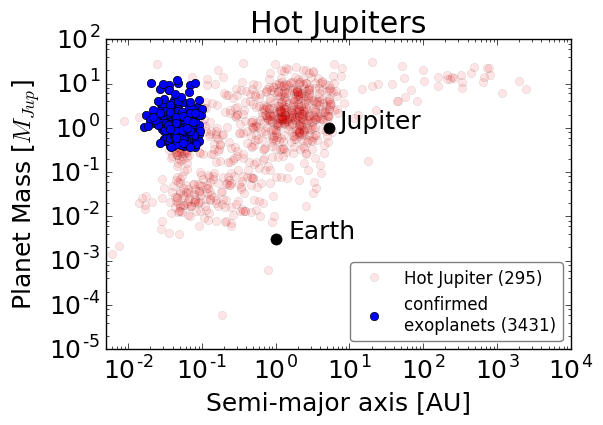

In [15]:
from matplotlib import pylab as pl
%pylab inline
matplotlib.rcParams.update({'font.size': 18})

#plot all
pl.plot(df['pl_orbsmax'],df['pl_bmassj'],'ro', alpha=0.1)
#plot Hot Jupiter
pl.plot(df_hot_jup['pl_orbsmax'],df_hot_jup['pl_bmassj'],'bo')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Mass [$M_{Jup}$]')
pl.xlim([5e-3, 1e4])
pl.title('Hot Jupiters')
#scale in log to avoid over-crowding
pl.xscale('log')
pl.yscale('log')
#indicate E and J
pl.plot(a_E/a_E,M_E/M_J,'ko', markersize=8, label='Earth')
pl.text(a_E/a_E+0.5,M_E/M_J,'Earth')
pl.plot(a_J/a_E,M_J/M_J,'ko', markersize=8, label='Jupiter')
pl.text(a_J/a_E+2,M_J/M_J,'Jupiter')
#pl.plot(a_N/a_E,M_N/M_J,'k^', markersize=15, label='Neptune')
label1=str('confirmed \nexoplanets ({})'.format(len(df)))
label2=str('Hot Jupiter ({})'.format(len(df_hot_jup)))
leg = pl.legend([label1,label2], fancybox=True, loc=4, numpoints = 1, fontsize=12)
leg.get_frame().set_alpha(0.5)
pl.show()

## Planet Period-Orbital radius plot

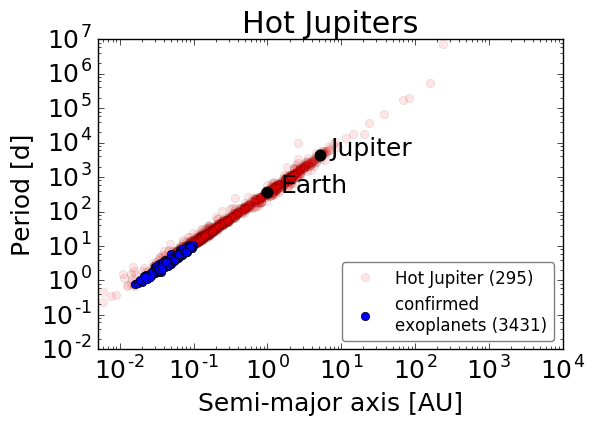

In [21]:
#plot all
pl.plot(df['pl_orbsmax'],df['pl_orbper'],'ro', alpha=0.1)
#plot Hot Jupiter
pl.plot(df_hot_jup['pl_orbsmax'],df_hot_jup['pl_orbper'],'bo')

pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Period [d]')
pl.xlim([5e-3, 1e4])
pl.title('Hot Jupiters')

#indicate E and J
pl.plot(a_E/a_E,P_E,'ko', markersize=8, label='Earth')
pl.text(a_E/a_E+0.5,P_E,'Earth')
pl.plot(a_J/a_E,P_J,'ko', markersize=8, label='Jupiter')
pl.text(a_J/a_E+2,P_J,'Jupiter')
#scale in log to avoid over-crowding
pl.xscale('log')
pl.yscale('log')

label1=str('Hot Jupiter ({})'.format(len(df_hot_jup)))
label2=str('confirmed \nexoplanets ({})'.format(len(df)))
leg = pl.legend([label1,label2], fancybox=True, loc=4, numpoints = 1, fontsize=12)
leg.get_frame().set_alpha(0.5)
pl.show()

Thus, we confirm the excess of objects that have orbital periods shorter than about 10 days and masses similar to that of Jupiter. This is starkly different from the orbital radius as a function of mass distribution of planets in the solar system.

The sharp cut/edge seen in the plot above probably implies that hot Jupiters do not occupy a distinct mass-orbital radius space among discovered exoplanets. However, there appears to be a distinct blob/ separate region beneath the hot jupiter regime which are super-Earths/mini-Neptunes discussed somewhere else. 

# 2. The objects rarely have companion planets on nearby orbits

Here we will consider Hot Jupiters in multi-planet systems. We start by filtering in our list stars with at least two planets. 

In [25]:
df.query('pl_pnum > 1').head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
6,HAT-P-13,b,Transit,2,2.916250,1.500000e-05,-1.500000e-05,0.0,6,NaN,...,0.0,4,1.56,0.08,-0.08,0.0,0.0,2,0,2014-10-15
10,HAT-P-17,b,Transit,2,10.338523,9.000000e-06,-9.000000e-06,0.0,1,0.088200,...,0.0,3,0.84,0.02,-0.02,0.0,0.0,2,0,2014-05-14
21,CoRoT-7,b,Transit,2,0.853592,5.700000e-07,-5.700000e-07,0.0,5,0.017016,...,0.0,4,0.82,0.02,-0.02,0.0,0.0,4,0,2015-03-05


In [26]:
df.query('pl_pnum > 1').shape

(1442, 83)

Therea are more than 1400 discovered multi-planetary systems. Let's group them by the number of planets in the system. Note that in each list, there is a possibility to include hot jupiters.

In [27]:
df2 = df[df['pl_pnum'] == 2] #have 2 planets
df3 = df[df['pl_pnum'] == 3] #3 and so on
df4 = df[df['pl_pnum'] == 4]
df5 = df[df['pl_pnum'] == 5]
df6 = df[df['pl_pnum'] == 6]
df7 = df[df['pl_pnum'] == 7] #up to seven planets only

Let's plot to see the distribution of the mass of multi-planet systems as a function of orbital radius. 

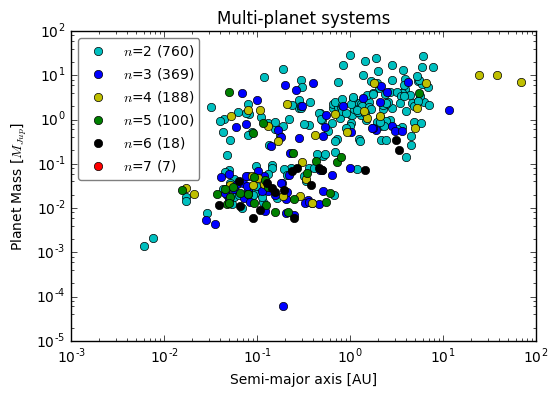

In [50]:
#plot each group
pl.plot(df2['pl_orbsmax'], df2['pl_bmassj'], 'co', label='$n$=2 ({})'.format(np.count_nonzero(df['pl_pnum']==2)))
pl.plot(df3['pl_orbsmax'], df3['pl_bmassj'], 'bo', label='$n$=3 ({})'.format(np.count_nonzero(df['pl_pnum']==3)))
pl.plot(df4['pl_orbsmax'], df4['pl_bmassj'], 'yo', label='$n$=4 ({})'.format(np.count_nonzero(df['pl_pnum']==4)))
pl.plot(df5['pl_orbsmax'], df5['pl_bmassj'], 'go', label='$n$=5 ({})'.format(np.count_nonzero(df['pl_pnum']==5)))
pl.plot(df6['pl_orbsmax'], df6['pl_bmassj'], 'ko', label='$n$=6 ({})'.format(np.count_nonzero(df['pl_pnum']==6)))
pl.plot(df7['pl_orbsmax'], df7['pl_bmassj'], 'ro', label='$n$=7 ({})'.format(np.count_nonzero(df['pl_pnum']==7)))

pl.title('Multi-planet systems')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Mass [$M_{Jup}$]')
pl.xscale('log')
pl.yscale('log')
#pl.plot(a_E/a_E,M_E/M_J,'ko', markersize=8, label='Earth')
#pl.text(a_E/a_E+0.5,M_E/M_J,'Earth')
#pl.plot(a_J/a_E,M_J/M_J,'ko', markersize=8, label='Jupiter')
#pl.text(a_J/a_E+2,M_J/M_J,'Jupiter')
#pl.legend(loc=4, numpoints = 1, fontsize=10)

leg = pl.legend(fancybox=True, loc='best', numpoints = 1, fontsize=10)
leg.get_frame().set_alpha(0.5)

We can see roughly their groupings. 2-planet systems ($n$=2) are scattered all over but predominantly towards upper right. $n$=5 and $n$=6 are clumped in the lower left. $n$=3 and $n$=4 have no obvious clumping. $n$=7 are not shown here because each of the planet's mass is not yet determined. 

Now, let's check see their period distribution.

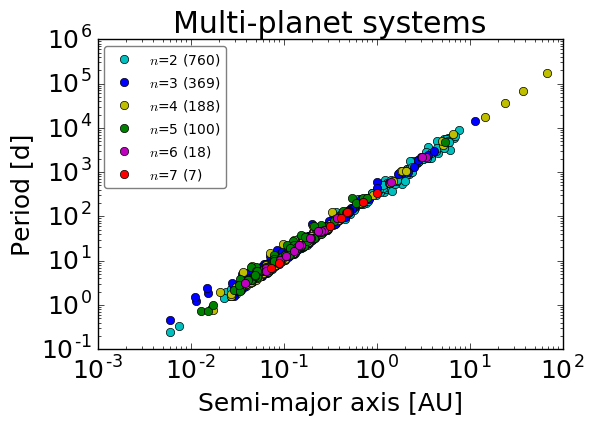

In [44]:
#plot each group
pl.plot(df2['pl_orbsmax'], df2['pl_orbper'], 'co', label='$n$=2 ({})'.format(np.count_nonzero(df['pl_pnum']==2)))
pl.plot(df3['pl_orbsmax'], df3['pl_orbper'], 'bo', label='$n$=3 ({})'.format(np.count_nonzero(df['pl_pnum']==3)))
pl.plot(df4['pl_orbsmax'], df4['pl_orbper'], 'yo', label='$n$=4 ({})'.format(np.count_nonzero(df['pl_pnum']==4)))
pl.plot(df5['pl_orbsmax'], df5['pl_orbper'], 'go', label='$n$=5 ({})'.format(np.count_nonzero(df['pl_pnum']==5)))
pl.plot(df6['pl_orbsmax'], df6['pl_orbper'], 'mo', label='$n$=6 ({})'.format(np.count_nonzero(df['pl_pnum']==6)))
pl.plot(df7['pl_orbsmax'], df7['pl_orbper'], 'ro', label='$n$=7 ({})'.format(np.count_nonzero(df['pl_pnum']==7)))

pl.title('Multi-planet systems')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Period [d]')
pl.xscale('log')
pl.yscale('log')
#pl.plot(a_E/a_E,P_E,'ko', markersize=8, label='Earth')
#pl.text(a_E/a_E+0.5,P_E,'Earth')
#pl.plot(a_J/a_E,P_J,'ko', markersize=8, label='Jupiter')
#pl.text(a_J/a_E+2,P_J,'Jupiter')
#pl.legend(loc=4, numpoints = 1, fontsize=10)

leg = pl.legend(fancybox=True, loc='best', numpoints = 1, fontsize=10)
leg.get_frame().set_alpha(0.5)

Here, we can see the case of $n$=7 occupying the center region. We also confirm the findings above that: 
* $n$=2 are scattered all over but predominantly towards upper right,
* $n$=5 and $n$=6 are clumped in the lower left,
* $n$=3 and $n$=4 have no obvious clumping. 

Now, let's see the configuration of some famous multiplanet systems. Let's start with $n$=7-system.

In [60]:
df7

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
699,KOI-351,b,Transit,7,7.008151,0.000019,-0.000019,0.0,1,0.074,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,0,2014-05-14
700,KOI-351,c,Transit,7,8.719375,0.000027,-0.000027,0.0,1,0.089,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,0,2014-05-14
701,KOI-351,d,Transit,7,59.736670,0.000380,-0.000380,0.0,2,0.320,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,0,2014-05-14
702,KOI-351,e,Transit,7,91.939130,0.000730,-0.000730,0.0,2,0.420,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,0,2014-05-14
703,KOI-351,f,Transit,7,124.914400,0.001900,-0.001900,0.0,1,0.480,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,0,2014-05-14
704,KOI-351,g,Transit,7,210.606970,0.000430,-0.000430,NaN,3,0.710,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,0,2014-05-14
705,KOI-351,h,Transit,7,331.600590,0.000370,-0.000370,0.0,3,1.010,...,0.0,2,1.2,0.1,-0.1,0.0,0.0,4,1,2014-05-14


Do the planets have measured masses?

In [63]:
df.query('pl_hostname == "KOI-351"')['pl_bmassj'].values #some masses unknown

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan])

No. (Why do you think so?)

Anyway, let's see their radii as a function of semi-major axis.

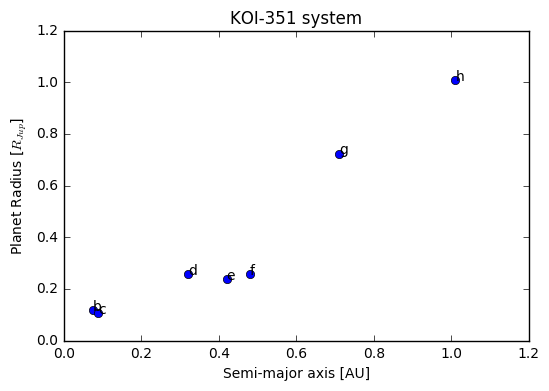

In [79]:
orbits = df.query('pl_hostname == "KOI-351"')['pl_orbsmax'].values
radii = df.query('pl_hostname == "KOI-351"')['pl_radj'].values
names = df.query('pl_hostname == "KOI-351"')['pl_letter'].values

pl.plot(orbits, radii, 'bo') # masses unknown
counter=0
for i,j in zip(orbits,radii):
    pl.text(i,j, names[counter])
    counter+=1
pl.title('KOI-351 system')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Radius [$R_{Jup}$]')

The system is compact (7 planets within 1 AU!)

Since they don't have measured masses, we can just their radii as proxy to masses. Note however that this is a bad approximation because Hot Jupiters may be prone to have [inflated atmospheres](http://phys.org/news/2016-09-astronomers-inflated-hot-jupiters.html). If these planets turn out to be in the order of a Jupiter-mass, then this is a clear counter-example showing several nearby companions.  

Let's just see how many stars that have $n=6$ planets.

In [76]:
df6['pl_hostname'].value_counts()

HD 219134    6
Kepler-11    6
HD 10180     6
Name: pl_hostname, dtype: int64

Let's pick Kepler-11 for some visualization.

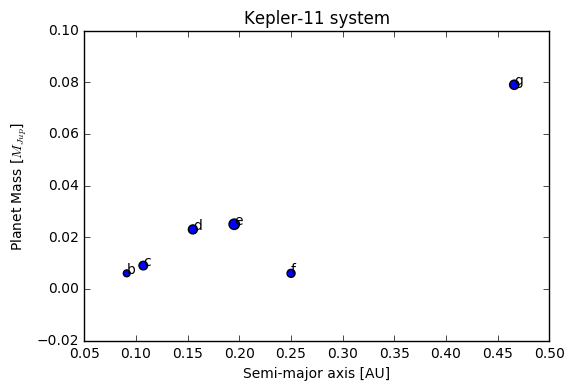

In [32]:
#very good example of multiplanet system
orbits = df.query('pl_hostname == "Kepler-11"')['pl_orbsmax'].values
masses = df.query('pl_hostname == "Kepler-11"')['pl_bmassj'].values 
radii = df.query('pl_hostname == "Kepler-11"')['pl_radj'].values
names = df.query('pl_hostname == "Kepler-11"')['pl_letter'].values

pl.scatter(orbits, masses, s=radii*150)
counter=0
for i,j in zip(orbits,masses):
    pl.text(i,j, names[counter])
    counter+=1
pl.title('Kepler-11 system')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Mass [$M_{Jup}$]')

Clearly, there are many compact multiple-planetary systems (a < 1 AU). This can be a result of detection bias using transit and RV observations.

## Counter example

We can check for counter examples by filtering for Hot Jupiters in multi-planet system. 

In [22]:
df_hot_jup.query('pl_pnum > 1').head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
10,HAT-P-17,b,Transit,2,10.338523,0.000009,-0.000009,0.0,1,0.0882,...,0.0,3,0.84,0.02,-0.02,0.0,0.0,2,0,2014-05-14
519,HD 187123,b,Radial Velocity,2,3.096583,0.000008,-0.000008,0.0,5,0.0426,...,0.0,4,NaN,NaN,NaN,NaN,0.0,1,0,2014-07-23
553,Kepler-23,b,Transit,3,7.107300,NaN,NaN,0.0,5,0.0750,...,0.0,4,1.55,0.05,-0.05,0.0,0.0,7,1,2014-05-14


In [23]:
df_hot_jup.query('pl_pnum > 1').shape

(18, 83)

There are about 18 in our list (again using our criteria defined at the beginning; we might get significantly different results if we vary the upper and lower bounds by a bit).

Let's see which Hot Jupiters have 2, 3, ..., companions in tight orbits and then plot them similar to what we did above.

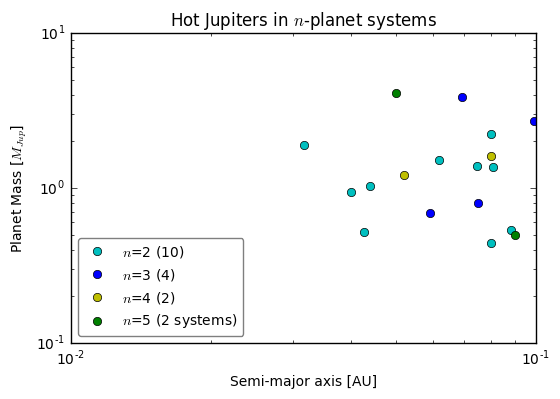

In [47]:
#make new dataframes
HJ2 = df_hot_jup[df_hot_jup['pl_pnum'] == 2]
HJ3 = df_hot_jup[df_hot_jup['pl_pnum'] == 3]
HJ4 = df_hot_jup[df_hot_jup['pl_pnum'] == 4]
HJ5 = df_hot_jup[df_hot_jup['pl_pnum'] == 5]
HJ6 = df_hot_jup[df_hot_jup['pl_pnum'] == 6]
HJ7 = df_hot_jup[df_hot_jup['pl_pnum'] == 7]

#plot each HJ
pl.plot(HJ2['pl_orbsmax'], HJ2['pl_bmassj'], 'co', label='$n$=2 ({})'.format(np.count_nonzero(df_hot_jup['pl_pnum']==2)))
pl.plot(HJ3['pl_orbsmax'], HJ3['pl_bmassj'], 'bo', label='$n$=3 ({})'.format(np.count_nonzero(df_hot_jup['pl_pnum']==3)))
pl.plot(HJ4['pl_orbsmax'], HJ4['pl_bmassj'], 'yo', label='$n$=4 ({})'.format(np.count_nonzero(df_hot_jup['pl_pnum']==4)))
pl.plot(HJ5['pl_orbsmax'], HJ5['pl_bmassj'], 'go', label='$n$=5 ({} systems)'.format(np.count_nonzero(df_hot_jup['pl_pnum']==5)))

pl.title('Hot Jupiters in $n$-planet systems')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Mass [$M_{Jup}$]')
pl.xscale('log')
pl.yscale('log')
#pl.plot(a_E/a_E,M_E/M_J,'ko', markersize=8, label='Earth')
#pl.text(a_E/a_E+0.5,M_E/M_J,'Earth')
#pl.plot(a_J/a_E,M_J/M_J,'ko', markersize=8, label='Jupiter')
#pl.text(a_J/a_E+2,M_J/M_J,'Jupiter')
#pl.legend(loc=4, numpoints = 1, fontsize=10)
leg = pl.legend(fancybox=True, loc=3, numpoints = 1, fontsize=10)
leg.get_frame().set_alpha(0.5)

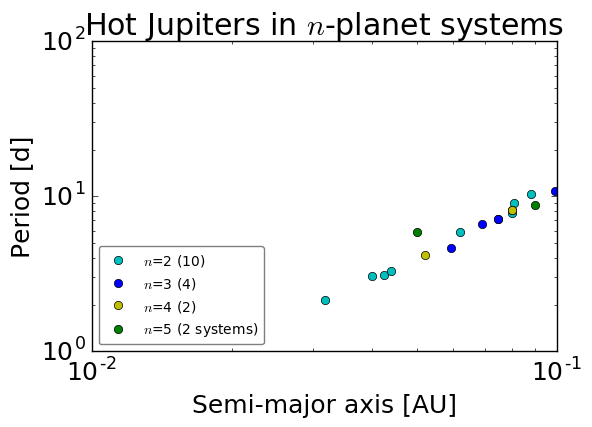

In [45]:
#plot each HJ
pl.plot(HJ2['pl_orbsmax'], HJ2['pl_orbper'], 'co', label='$n$=2 ({})'.format(np.count_nonzero(df_hot_jup['pl_pnum']==2)))
pl.plot(HJ3['pl_orbsmax'], HJ3['pl_orbper'], 'bo', label='$n$=3 ({})'.format(np.count_nonzero(df_hot_jup['pl_pnum']==3)))
pl.plot(HJ4['pl_orbsmax'], HJ4['pl_orbper'], 'yo', label='$n$=4 ({})'.format(np.count_nonzero(df_hot_jup['pl_pnum']==4)))
pl.plot(HJ5['pl_orbsmax'], HJ5['pl_orbper'], 'go', label='$n$=5 ({} systems)'.format(np.count_nonzero(df_hot_jup['pl_pnum']==5)))

pl.title('Hot Jupiters in $n$-planet systems')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Period [d]')
pl.xscale('log')
pl.yscale('log')
leg = pl.legend(fancybox=True, loc=3, numpoints = 1, fontsize=10)
leg.get_frame().set_alpha(0.5)

It's quite difficult to see the relation due to the sparsity of the data. Perhaps, it is better to see the histogram of their orbital radius.

Populating the interactive namespace from numpy and matplotlib


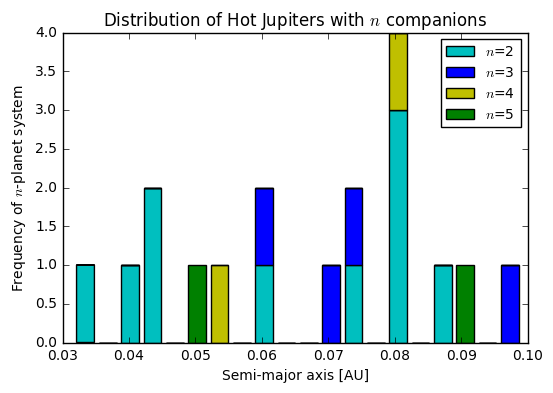

In [46]:
from matplotlib import pylab as pl
%pylab inline
#style.use('fivethirtyeight')
colors = ['c','b','y','g']
labels = ['$n$=2','$n$=3','$n$=4','$n$=5']

pl.hist([HJ2['pl_orbsmax'],HJ3['pl_orbsmax'],HJ4['pl_orbsmax'],HJ5['pl_orbsmax']], bins=20, color=colors, stacked=True, label=labels)
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Frequency of $n$-planet system')
pl.title('Distribution of Hot Jupiters with $n$ companions')
pl.legend(loc=1, fontsize=10)

The plot shows Hot Jupiters in multi-planet systems. Most of them are in very tight orbits leaning close to our set upper bound of 0.1 AU.

Next we wish to see the distribution of semi-major for a given multi-planet system and check whether there are planets close to the Hot Jupiter. Let's start with $n$=5.

In [56]:
HJ5

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
571,Kepler-32,b,Transit,5,5.90124,0.0001,-0.0001,0.0,8,0.05,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24
572,Kepler-32,c,Transit,5,8.75220,0.0003,-0.0003,0.0,8,0.09,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24


As a counter example, we can see Kepler-32 having 2 hot-Jupiters slightly close to one another. Let's see the details of the other three planets. 

In [23]:
df.query('pl_hostname == "Kepler-32"')

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
100,Kepler-32,b,Transit,5,5.90124,0.00010,-0.00010,0.0,8,0.050,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24
101,Kepler-32,d,Transit,5,22.78020,0.00050,-0.00050,0.0,7,0.130,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24
102,Kepler-32,f,Transit,5,0.74296,0.00007,-0.00007,0.0,4,0.013,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24
103,Kepler-32,c,Transit,5,8.75220,0.00030,-0.00030,0.0,8,0.090,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24
3175,Kepler-32,e,Transit,5,2.89600,0.00030,-0.00030,0.0,6,0.033,...,0.0,7,0.53,0.04,-0.04,0.0,0.0,9,1,2016-03-24


In [54]:
df.query('pl_hostname == "Kepler-32"')['pl_orbsmax'].values

array([ 0.05 ,  0.09 ,  0.13 ,  0.013,  0.033])

The Hot Jupiters are Kepler-32 f and e (i.e. they have 0.74 and 2.89 day period, respectively). Since they are transiting planets, primarily their periods and radii are known. Before plotting, let's check if they have measured mass.

In [24]:
masses = df.query('pl_hostname == "Kepler-32"')['pl_bmassj'].values #some masses unknown
masses

array([ 4.1,  nan,  nan,  0.5,  nan])

Only 2 out of 5 have measured mass. This can later turn out to be much anomalous (having more compact hot Jupiter) if they happen to have Jupiter-masses after measurement (if possible).

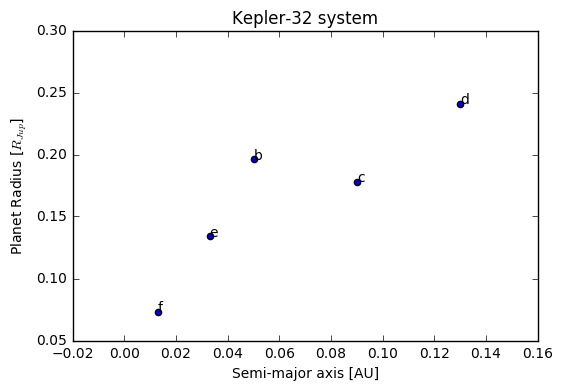

In [28]:
orbits = df.query('pl_hostname == "Kepler-32"')['pl_orbsmax'].values
masses = df.query('pl_hostname == "Kepler-32"')['pl_bmassj'].values #some masses unknown
radii = df.query('pl_hostname == "Kepler-32"')['pl_radj'].values
names = df.query('pl_hostname == "Kepler-32"')['pl_letter'].values

pl.scatter(orbits, radii)#, s=masses)
counter=0
for i,j in zip(orbits,radii):
    pl.text(i,j, names[counter])
    counter+=1
pl.title('Kepler-32 system')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Radius [$R_{Jup}$]')

This is one counter-example of a Hot Jupiter with another HJ close to its orbit. Let's see other systems.

In [21]:
df.query('pl_hostname == "55 Cnc"')
#df.query('pl_hostname == "55 Cnc"')['pl_orbsmax'].values

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
293,55 Cnc,b,Radial Velocity,5,14.651520,0.000150,-0.000150,0.0,10,0.115227,...,0.0,11,0.94,0.01,-0.01,0.0,0.0,6,0,2014-10-29
294,55 Cnc,c,Radial Velocity,5,44.417500,0.007300,-0.007300,0.0,6,0.241376,...,0.0,11,0.94,0.01,-0.01,0.0,0.0,6,0,2014-10-29
295,55 Cnc,e,Radial Velocity,5,0.736539,0.000007,-0.000007,0.0,8,0.015440,...,0.0,11,0.94,0.01,-0.01,0.0,0.0,6,1,2016-07-07
296,55 Cnc,f,Radial Velocity,5,262.000000,0.510000,-0.510000,0.0,5,0.788000,...,0.0,11,0.94,0.01,-0.01,0.0,0.0,6,0,2014-10-29
2208,55 Cnc,d,Radial Velocity,5,4825.000000,39.000000,-39.000000,0.0,8,5.503000,...,0.0,11,0.94,0.01,-0.01,0.0,0.0,6,0,2014-10-29


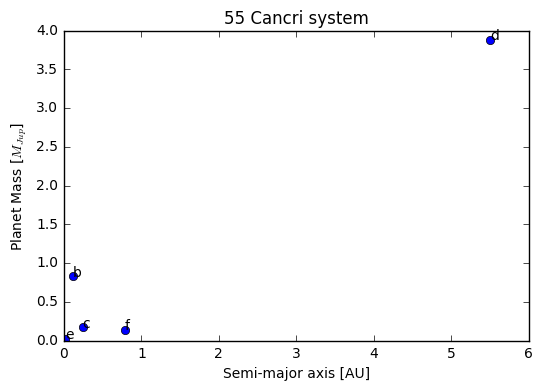

In [22]:
orbits = df.query('pl_hostname == "55 Cnc"')['pl_orbsmax'].values
masses = df.query('pl_hostname == "55 Cnc"')['pl_bmassj'].values
#radii = df.query('pl_hostname == "55 Cnc"')['pl_radj'].values  #radii unknown
names = df.query('pl_hostname == "55 Cnc"')['pl_letter'].values

pl.plot(orbits, masses, 'o')#, markersize=radii)
counter=0
for i,j in zip(orbits,masses):
    pl.text(i,j, names[counter])
    counter+=1
pl.title('55 Cancri system')
pl.xlabel('Semi-major axis [AU]')
pl.ylabel('Planet Mass [$M_{Jup}$]')

55 Cancri is a good example of a compact (i.e. $a$ < 1 AU) hot Jupiter system. 55 Cancri e, c, and f, however have less than 0.5 $M_{Jup}$ but still falls in the Jupiter-mass regime. 55 Cancri d is seen to be  very distant away from the 4 inner planets.

Now, let's proceed to HJ's in $n$=4,3,2 configurations.

In [55]:
HJ4

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
555,Kepler-24,b,Transit,4,8.14530,NaN,NaN,0.0,4,0.080,...,0.0,3,1.29,0.29,-0.29,0.0,0.0,6,1,2014-05-14
2199,WASP-47,b,Transit,4,4.16071,0.00038,-0.00038,0.0,6,0.052,...,0.0,6,1.16,0.26,-0.26,0.0,0.0,6,1,2016-12-01


In [57]:
HJ3

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
553,Kepler-23,b,Transit,3,7.107300,NaN,NaN,0.0,5,0.075000,...,0.0,4,1.55,0.05,-0.05,0.0,0.0,7,1,2014-05-14
853,ups And,b,Radial Velocity,3,4.617033,0.000023,-0.000023,0.0,5,0.059222,...,0.0,5,1.56,NaN,NaN,0.0,0.0,2,0,2014-05-14
1722,Kepler-23,c,Transit,3,10.742100,NaN,NaN,0.0,5,0.099000,...,0.0,4,1.55,0.05,-0.05,0.0,0.0,7,1,2014-05-14
2780,HIP 14810,b,Radial Velocity,3,6.673855,0.000019,-0.000019,0.0,3,0.069200,...,0.0,4,1.00,0.06,-0.06,0.0,0.0,2,0,2015-05-14


In [58]:
HJ2

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
10,HAT-P-17,b,Transit,2,10.338523,9.000000e-06,-9.000000e-06,0.0,1,0.08820,...,0.0,3,0.84,0.02,-0.02,0.0,0.0,2,0,2014-05-14
519,HD 187123,b,Radial Velocity,2,3.096583,7.800000e-06,-7.800000e-06,0.0,5,0.04260,...,0.0,4,NaN,NaN,NaN,NaN,0.0,1,0,2014-07-23
564,Kepler-28,c,Transit,2,8.985800,NaN,NaN,0.0,5,0.08100,...,0.0,4,0.70,NaN,NaN,0.0,0.0,6,1,2014-05-14
589,KELT-6,b,Transit,2,7.845582,7.000000e-06,-7.000000e-06,0.0,2,0.08000,...,0.0,2,1.53,0.14,-0.14,0.0,0.0,2,0,2015-09-03
2059,Kepler-424,b,Transit,2,3.311864,3.900000e-07,-3.900000e-07,0.0,3,0.04400,...,0.0,1,0.94,0.06,-0.06,0.0,0.0,3,1,2014-10-03
2117,Pr0211,b,Radial Velocity,2,2.146100,3.000000e-05,-3.000000e-05,0.0,2,0.03176,...,0.0,2,0.83,0.01,-0.01,0.0,0.0,2,0,2016-02-11
2141,WASP-8,b,Transit,2,8.158715,1.600000e-05,-1.500000e-05,0.0,3,0.08010,...,NaN,3,0.94,0.05,NaN,0.0,NaN,2,0,2014-05-14
2945,WASP-41,b,Transit,2,3.052404,9.000000e-07,-9.000000e-07,0.0,3,0.04000,...,0.0,4,0.87,0.03,-0.03,0.0,0.0,4,0,2015-10-15
3158,Kepler-28,b,Transit,2,5.912300,NaN,NaN,0.0,5,0.06200,...,0.0,4,0.70,NaN,NaN,0.0,0.0,6,1,2014-05-14
3356,HD 217107,b,Radial Velocity,2,7.126816,3.900000e-05,-3.900000e-05,0.0,4,0.07480,...,0.0,6,NaN,NaN,NaN,NaN,0.0,3,0,2014-05-14


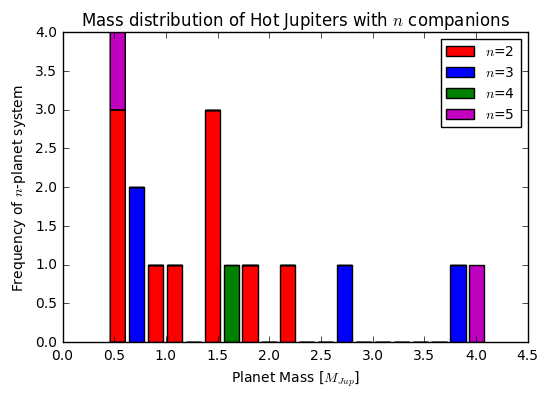

In [33]:
colors = ['r','b','g','m']
labels = ['$n$=2','$n$=3','$n$=4','$n$=5']
pl.hist([HJ2['pl_bmassj'],HJ3['pl_bmassj'],HJ4['pl_bmassj'],HJ5['pl_bmassj']], bins=20, color=colors, stacked=True, label=labels)
pl.xlabel('Planet Mass [$M_{Jup}$]')
pl.ylabel('Frequency of $n$-planet system')
pl.title('Mass distribution of Hot Jupiters with $n$ companions')
pl.legend(loc=1, fontsize=10)
#pl.text(x,y,'')

Beware of duplication in the histogram above. Imagine three-planet system with 2 hot jupiters. They will both stack at $n$=3. 

Due to the sparsity of the data, it is still difficult to confirm the observed property of Hot Jupyters having few nearby companions. What we've shown above is actually the opposite i.e. that there are HJ that have adjacent orbits although this is true for very few systems. 

# 3. Nearly one-third of hot Jupiters have orbital paths that are inclined with respect to their star's equator, and several planets in the population rotate in the opposite direction to the star

The first point is concerned with orbital inclination of Hot Jupiters and the second is their direction of revolution with respect to the rotation of the star. If this motions are opposite in direction, it is called retrograde motion. Otherwise, it is called prograde motion and this is true for the solar system (i.e. perceived "normal").

## Inclination of HJ

Let's see how many HJ have inclination, $i > 45^{\circ}$. Note that solar system planets are inclined at most 7$^{\circ}$ (in the case of Mercury) relative to the ecliptic (or Earth's orbital plane).

In [81]:
df_hot_jup.query('pl_orbincl > 45').head().shape

(5, 83)

There are at least 5 of them. Let's quickly check some. 

In [80]:
df_hot_jup.query('pl_orbincl > 45').head()

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
0,HAT-P-3,b,Transit,1,2.899736,0.000002,-0.000002,0.0,6,0.03866,...,0.0,4,0.80,0.04,-0.04,0.0,0.0,5,0,2014-05-14
1,HAT-P-5,b,Transit,1,2.788491,0.000025,-0.000025,0.0,2,0.04075,...,0.0,2,1.17,0.05,-0.05,0.0,0.0,2,0,2014-05-14
2,HAT-P-6,b,Transit,1,3.852985,0.000005,-0.000005,0.0,3,0.05235,...,0.0,5,1.46,0.06,-0.06,0.0,0.0,4,0,2014-05-14
3,HAT-P-8,b,Transit,1,3.076378,0.000004,-0.000004,0.0,1,0.04870,...,NaN,3,1.58,0.08,NaN,0.0,NaN,2,0,2014-05-14
4,HAT-P-9,b,Transit,1,3.922890,0.000040,-0.000040,0.0,2,0.05300,...,NaN,2,1.32,0.07,NaN,0.0,NaN,2,0,2014-05-14


Now, let's see the histogram of their inclination.

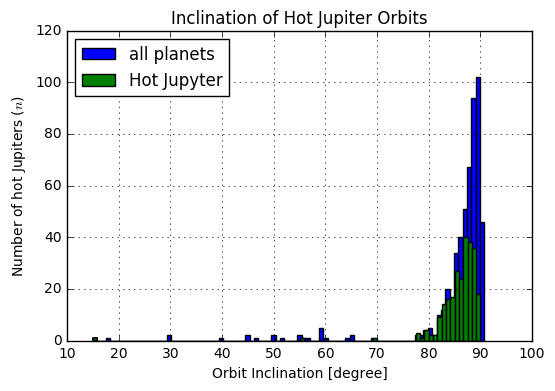

In [86]:
df['pl_orbincl'].hist(bins=90, color='b', label='all planets')
df_hot_jup['pl_orbincl'].hist(bins=90, color='g', label='Hot Jupyter')
pl.xlabel('Orbit Inclination [degree]')
pl.ylabel('Number of hot Jupiters ($n$)')
pl.title('Inclination of Hot Jupiter Orbits')
pl.legend(loc='best')

The distribution is concentrated on edge-on orbits because most of inclination measurements are done using transit techniques which preferentially detects planets that are edge-on as viewed from Earth. This plot therefore is biased.

It is difficult to show the whether the orbit of HJ are indeed mostly retrograde due to sparsity of data. To do this, we have to know the direction of stellar spin and orbital inclination of the planet. 

Now let's just check whether almost a third of HJ have inclined orbits. 

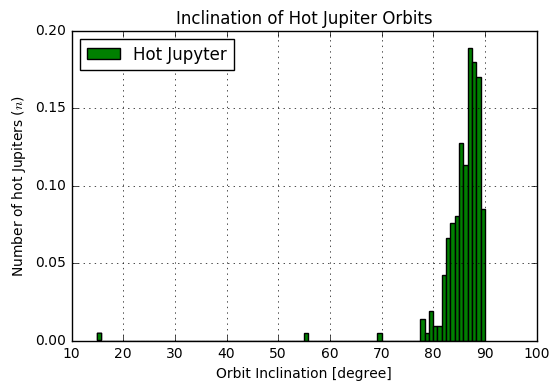

In [87]:
#normalized histogram
df_hot_jup['pl_orbincl'].hist(bins=90, normed=True, color='g', label='Hot Jupyter')
pl.xlabel('Orbit Inclination [degree]')
pl.ylabel('Number of hot Jupiters ($n$)')
pl.title('Inclination of Hot Jupiter Orbits')
pl.legend(loc='best')

We see above that about 20% of HJ have almost edge-on orbits.

## Retrograde HJ

HAT-P-7 is most likely the first result is you do a google search for "retrograde exoplanet". Let's check if this system has a hot Jupyter.

In [36]:
df_hot_jup.query('pl_hostname == "HAT-P-7"')

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
120,HAT-P-7,b,Transit,1,2.204737,0.000001,-0.000001,0.0,7,0.03676,...,0.0,8,1.84,0.17,-0.17,0.0,0.0,8,1,2016-08-18


Indeed, it has one HJ.

How about systems with 2 hot Jupiters with inclined orbits?

In [37]:
df_hot_jup.query('pl_pnum == 2 and pl_orbincl >50')#['pl_orbincl']

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,...,st_massblend,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radblend,st_radn,pl_nnotes,rowupdate
118,KELT-6,b,Transit,2,7.845582,7.000000e-06,-7.000000e-06,0.0,2,0.0800,...,0.0,2,1.53,0.14,-0.14,0.0,0.0,2,0,2015-09-03
1336,HAT-P-17,b,Transit,2,10.338523,9.000000e-06,-9.000000e-06,0.0,1,0.0882,...,0.0,3,0.84,0.02,-0.02,0.0,0.0,2,0,2014-05-14
1864,WASP-41,b,Transit,2,3.052404,9.000000e-07,-9.000000e-07,0.0,3,0.0400,...,0.0,4,0.87,0.03,-0.03,0.0,0.0,4,0,2015-10-15
2676,WASP-8,b,Transit,2,8.158715,1.600000e-05,-1.500000e-05,0.0,3,0.0801,...,NaN,3,0.94,0.05,NaN,0.0,NaN,2,0,2014-05-14


Therefore, (not taking into account detection bias) we have seen that hot Jupyters are mostly inclined and there are some that are also prograde. 

Before we finish, it's worth checking the mass-radius relation of HJ and compare the result for planets grouped via their detection method.

## Mass-radius relation of hot Jupiters

In [88]:
idx1 = df['pl_discmethod'] == 'Transit'
df_transit = df[idx1]

idx2 = df['pl_discmethod'] == 'Radial Velocity'
df_RV = df[idx2]

idx3 = df['pl_discmethod'] == 'Imaging'
df_DI = df[idx3]

idx4 = df['pl_discmethod'] == 'Microlensing'
df_ML = df[idx4]

idx5 = df['pl_discmethod'] == 'Astrometry'
df_A = df[idx5]

idx6 = df['pl_discmethod'] == 'Transit Timing Variations'
df_TTV = df[idx6]

idx7 = df['pl_discmethod'] == 'Eclipse Timing Variations'
df_ETV = df[idx7]

idx8 = df['pl_discmethod'] == 'Pulsar Timing'
df_PT = df[idx8]

idx9 = df['pl_discmethod'] == 'Pulsation Timing Variations'
df_PTV = df[idx9]

idx10 = df['pl_discmethod'] == 'Orbital Brightness Modulation'
df_OBM = df[idx10]

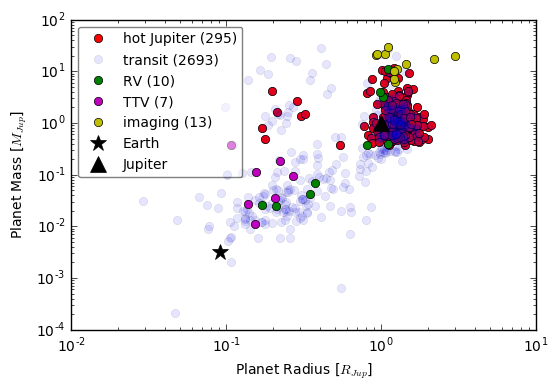

In [92]:
pl.plot(df_hot_jup['pl_radj'],df_hot_jup['pl_bmassj'],'ro', label='hot Jupiter ({})'.format(len(df_hot_jup)))
pl.plot(df_transit['pl_radj'],df_transit['pl_bmassj'],'bo', alpha=0.1, label='transit ({})'.format(np.count_nonzero(df_transit['pl_radj']>0)))
pl.plot(df_RV['pl_radj'],df_RV['pl_bmassj'],'go', label='RV ({})'.format(np.count_nonzero(df_RV['pl_radj']>0)))
pl.plot(df_TTV['pl_radj'],df_TTV['pl_bmassj'],'mo', label='TTV ({})'.format(np.count_nonzero(df_TTV['pl_radj']>0)))
pl.plot(df_DI['pl_radj'],df_DI['pl_bmassj'],'yo', label='imaging ({})'.format(np.count_nonzero(df_DI['pl_radj']>0)))
pl.xlabel('Planet Radius [$R_{Jup}$]')
pl.ylabel('Planet Mass [$M_{Jup}$]')
#pl.xlim([5e-3, 1e5])
pl.xscale('log')
pl.yscale('log')
pl.plot(R_E/R_J,M_E/M_J,'k*', markersize=12, label='Earth')
pl.plot(1,1,'k^', markersize=12, label='Jupiter')
leg = pl.legend(fancybox=True, loc=2, numpoints = 1, fontsize=10)
leg.get_frame().set_alpha(0.5)

As mentioned above, there is extreme overlap in the region/parameter space occupied by hot Jupiters (red) and other confirmed exoplanets (e.g. blue).  

# Stellar properties (To be updated)

This is some sample plots.

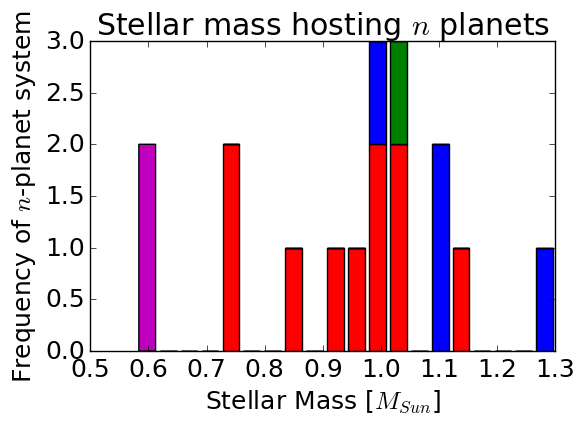

In [40]:
colors = ['r','b','g','m']
labels = ['$n$=2','$n$=3','$n$=4','$n$=5']
pl.hist([HJ2['st_mass'],HJ3['st_mass'],HJ4['st_mass'],HJ5['st_mass']], bins=20, color=colors, stacked=True, label=labels)
pl.xlabel('Stellar Mass [$M_{Sun}$]')
pl.ylabel('Frequency of $n$-planet system')
pl.title('Stellar mass hosting $n$ planets')
#pl.legend()

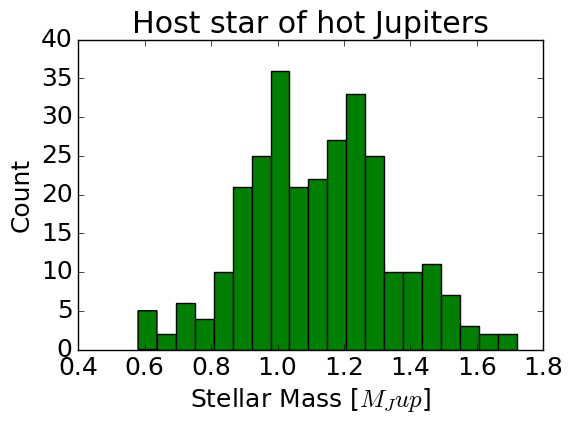

In [41]:
colors = ['r','b','g','m']
labels = ['$n$=2','$n$=3','$n$=4','$n$=5']
#pl.hist([HJ2['st_mass'],HJ3['st_mass'],HJ4['st_mass'],HJ5['st_mass']], bins=20, color=colors, stacked=True, label=labels)
pl.hist(df_hot_jup['st_mass'], bins=20, color='g')
pl.xlabel('Stellar Mass [$M_Jup$]')
pl.ylabel('Count')
pl.title('Host star of hot Jupiters')

## Formation and Evolution
* [wiki](https://en.wikipedia.org/wiki/Hot_Jupiter#Migration)

### Inward Migration
* a hot Jupiter forms beyond the frost line, from rock, ice, and gases via the core accretion method of planetary formation. 
* The planet then migrates inwards to the star where it eventually forms a stable orbit. 
* The planet may have migrated inward smoothly via 
 * type II orbital migration; or more suddenly due to 
 * gravitational scattering onto eccentric orbits during an encounter with another massive planet, followed by the circularization and shrinking of the orbits due to tidal interactions with the star. 
* A hot Jupiter's orbit could also have been altered via the Kozai mechanism, causing an exchange of inclination for eccentricity resulting in a high eccentricity low perihelion orbit, in combination with tidal friction. 
* This requires a massive body -- another planet or a stellar companion -- on a more distant and inclined orbit; approximately 50% of hot Jupiters have distant Jupiter-mass or larger companions, which can leave the hot Jupiter with an orbit inclined relative to the star's rotation.[21]

* The type II migration happens during the solar nebula phase, i.e. when gas is still present. Energetic stellar photons and strong stellar winds at this time remove most of the remaining nebula. Migration via the other mechanism can happen after the loss of the gas disk.

### In situ
*  the cores of the hot Jupiters began as more common super-Earths which accreted their gas envelopes at their current locations, becoming gas giants in situ. 
* The super-Earths providing the cores in this hypothesis could have formed either in situ or at greater distances and have undergone migration before acquiring their gas envelopes. 
* Since super-Earths are often found with companions, the hot Jupiters formed in situ could also be expected to have companions. The increase of the mass of the locally growing hot Jupiter has a number of possible effects on neighboring planets. 
* If the hot Jupiter maintains an eccentricity greater than 0.01, sweeping secular resonances can increase the eccentricity of a companion planet, causing it to collide with the hot Jupiter. 
* The core of the hot Jupiter in this case would be unusually large. 
* If the hot Jupiter's eccentricity remains small the sweeping secular resonances could also tilt the orbit of the companion.
* Traditionally, the in situ mode of conglomeration has been disfavored because the assembly of massive cores, which is necessary for the formation of hot Jupiters, requires surface densities of solids ≈ 104 g/cm2, or larger.
* Recent surveys, however, have found that the inner regions of planetary systems are frequently occupied by super-Earth type planets.
* If these super-Earths formed at greater distances and migrated closer, the formation of in situ hot Jupiters is not entirely in situ.



## examples
* [WASP-47 b, +c,d](https://arxiv.org/pdf/1508.02411.pdf)